# BigMart Sales Prediction
This notebook covers:
- EDA
- Imputation, outlier capping, imbalance handling
- Feature engineering
- Base models: XGBoost, CatBoost, LightGBM (Optuna)
- **Tier-wise modeling** (per Outlet_Type)
- Model blending
- Submission file


## 1. Install dependencies (if needed)

In [1]:
# !pip install xgboost lightgbm catboost optuna plotly category_encoders --quiet

## 2. Import libraries and load data

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
import optuna
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

c:\Users\320189974\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
TRAIN_PATH = Path('C:/Users/320189974/OneDrive - Philips/Projects/ABB/train_v9rqX0R.csv')
TEST_PATH  = Path('C:/Users/320189974/OneDrive - Philips/Projects/ABB/test_AbJTz2l.csv')
SAMPLE_SUB_PATH = Path('C:/Users/320189974/OneDrive - Philips/Projects/ABB/sample_submission_8RXa3c6.csv')

assert TRAIN_PATH.exists(), 'Train file missing'; assert TEST_PATH.exists(), 'Test file missing'

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
sample = pd.read_csv(SAMPLE_SUB_PATH)

## 4. EDA

In [4]:
# Combine for unified EDA
train['source'] = 'train'
test['source'] = 'test'
test['Item_Outlet_Sales'] = np.nan
data = pd.concat([train, test], ignore_index=True)

In [27]:
sample.columns

Index(['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales_x',
       'Item_Outlet_Sales_y'],
      dtype='object')

In [5]:
# Dataset overview

# Dataset structure
print("Train shape:", train.shape)
print("Test shape :", test.shape)

# Column types
display(data.dtypes)

# Missing values
missing = data.isnull().mean().sort_values(ascending=False)
missing = missing[missing > 0].reset_index()
missing.columns = ['Column', 'Missing %']
px.bar(missing, x='Column', y='Missing %', title='Missing Values in Dataset')


Train shape: (8523, 13)
Test shape : (5681, 13)


Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
source                        object
dtype: object

In [6]:
# Target Variable Distribution

# Distribution of target
px.histogram(train, x='Item_Outlet_Sales', nbins=50,
             title='Distribution of Item_Outlet_Sales')

In [7]:
# Outlet-Level Sales Analysis

# Mean sales per outlet
outlet_sales = train.groupby('Outlet_Identifier')['Item_Outlet_Sales'].mean().reset_index()
px.bar(outlet_sales, x='Outlet_Identifier', y='Item_Outlet_Sales',
       title='Average Sales per Outlet', color='Item_Outlet_Sales')

In [8]:
# Sales by Item Type

px.box(train, x='Item_Type', y='Item_Outlet_Sales', title='Sales by Item Type',
       color='Item_Type', height=600)

In [9]:
# Fat Content vs Sales

px.box(train, x='Item_Fat_Content', y='Item_Outlet_Sales',
       title='Item Fat Content vs Sales', color='Item_Fat_Content')

In [10]:
# Outlet Type vs Sales

px.box(train, x='Outlet_Type', y='Item_Outlet_Sales',
       title='Outlet Type vs Sales', color='Outlet_Type')

In [11]:
# Outlet Establishment Year

outlet_year = train.groupby('Outlet_Establishment_Year')['Item_Outlet_Sales'].mean().reset_index()
px.line(outlet_year, x='Outlet_Establishment_Year', y='Item_Outlet_Sales',
        markers=True, title='Average Sales by Establishment Year')

In [12]:
# Item Visibility vs Sales (Binned)

# Create a copy for EDA without touching the original
train_eda = train.copy()

# Custom bin labels for visibility
visibility_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

# Now apply your binning and Plotly logic to `train_eda`
train_eda['Visibility_Bin'] = pd.qcut(train_eda['Item_Visibility'], q=5, labels=visibility_labels)

fig = px.box(
    train_eda,
    x='Visibility_Bin',
    y='Item_Outlet_Sales',
    title='👁️ Item Visibility (Binned) vs Sales',
    color='Visibility_Bin',
    labels={'Item_Outlet_Sales': 'Sales', 'Visibility_Bin': 'Visibility Level'},
    template='plotly_white'
)
fig.update_layout(showlegend=False)
fig.show()


In [13]:
# Item MRP Distribution

px.histogram(train, x='Item_MRP', nbins=60, title='Item MRP Distribution')

## 5. Missing Value Imputation

In [14]:
# Item_Weight: fill with item mean
data['Item_Weight'] = data.groupby('Item_Identifier')['Item_Weight'].transform(lambda x: x.fillna(x.mean()))
# Item_Visibility: 0 means missing
data['Item_Visibility'].replace(0, np.nan, inplace=True)
data['Item_Visibility'].fillna(data['Item_Visibility'].median(), inplace=True)

## 6. Outlier Capping

In [15]:
# Cap extreme sales only for training
q_hi = train['Item_Outlet_Sales'].quantile(0.99)
data.loc[(data['source']=='train') & (data['Item_Outlet_Sales'] > q_hi), 'Item_Outlet_Sales'] = q_hi

## 7. Feature Engineering

In [16]:
data['Outlet_Years'] = 2025 - data['Outlet_Establishment_Year']
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'})
data['Item_Category'] = data['Item_Identifier'].str[0].map({'F':'Food', 'D':'Drinks', 'N':'Non-Consumable'})
data['Is_Non_Edible'] = (data['Item_Category']=='Non-Consumable').astype(int)

## 8. Handle Imbalanced Categories

In [17]:
# Group less frequent Item_Type
rare_types = data['Item_Type'].value_counts()[data['Item_Type'].value_counts()<100].index
data['Item_Type'] = data['Item_Type'].replace(rare_types, 'Other')

## 9. Split Processed Data

In [18]:
final_train = data[data['source']=='train'].drop(['source'], axis=1)
final_test  = data[data['source']=='test'].drop(['source','Item_Outlet_Sales'], axis=1)
X = final_train.drop('Item_Outlet_Sales', axis=1)
y = final_train['Item_Outlet_Sales']
X_test = final_test.copy()

## 10. Preprocessing Pipeline

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()

num_tf = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])
cat_tf = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer([
    ('num', num_tf, num_cols),
    ('cat', cat_tf, cat_cols)
])

## 11. XGBoost Baseline

In [20]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer

xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=8, subsample=0.8,
                         colsample_bytree=0.8, objective='reg:squarederror', tree_method='hist', random_state=42)

pipeline_xgb = Pipeline([
    ('prep', preprocessor),
    ('model', xgb_model)
])

rmse = make_scorer(lambda yt, yp: np.sqrt(mean_squared_error(yt, yp)), greater_is_better=False)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline_xgb, X, y, scoring=rmse, cv=kf, n_jobs=-1)
print(f'XGBoost CV RMSE: {abs(cv_scores.mean()):.4f}')

pipeline_xgb.fit(X, y)
pred_xgb = pipeline_xgb.predict(X_test)

XGBoost CV RMSE: 1094.3057


## 12. CatBoost with CV

In [21]:
from catboost import CatBoostRegressor, Pool, cv as cb_cv

cat_idx = [X.columns.get_loc(c) for c in cat_cols]
X_cb = X.copy(); X_cb[cat_cols] = X_cb[cat_cols].fillna('Missing')
X_test_cb = X_test.copy(); X_test_cb[cat_cols] = X_test_cb[cat_cols].fillna('Missing')

cb_params = dict(loss_function='RMSE', iterations=1500, learning_rate=0.05, depth=6,
                l2_leaf_reg=3, random_seed=42, verbose=False)

data_pool = Pool(X_cb, y, cat_features=cat_idx)
cv_result = cb_cv(params=cb_params, pool=data_pool, fold_count=5, partition_random_seed=42, verbose=False)
print('CatBoost CV RMSE:', cv_result['test-RMSE-mean'].mean())

cat_model = CatBoostRegressor(**cb_params)
cat_model.fit(X_cb, y, cat_features=cat_idx, verbose=False)
pred_cat = cat_model.predict(X_test_cb)

Training on fold [0/5]

bestTest = 1044.322068
bestIteration = 182

Training on fold [1/5]

bestTest = 1043.407179
bestIteration = 196

Training on fold [2/5]

bestTest = 1005.943654
bestIteration = 339

Training on fold [3/5]

bestTest = 1043.152916
bestIteration = 217

Training on fold [4/5]

bestTest = 1050.148496
bestIteration = 191

CatBoost CV RMSE: 1060.2793365271966


## 13. LightGBM with Optuna

In [23]:
import optuna
import lightgbm as lgb

# Convert all object columns to categorical (LightGBM will handle it internally)
X_lgb = X.copy()
X_test_lgb = X_test.copy()
for col in X_lgb.select_dtypes(include='object').columns:
    X_lgb[col] = X_lgb[col].astype('category')
    X_test_lgb[col] = X_test_lgb[col].astype('category')

# Optuna objective function
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 31, 128),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'random_state': 42
    }
    model = lgb.LGBMRegressor(**params)
    cv = cross_val_score(model, X_lgb, y, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)
    return -cv.mean()

# Optimize with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30, show_progress_bar=True)

# Train final model
print('Best parameters:', study.best_params)
lgb_model = lgb.LGBMRegressor(**study.best_params)
lgb_model.fit(X_lgb, y)
pred_lgb = lgb_model.predict(X_test_lgb)

[I 2025-08-07 12:34:00,010] A new study created in memory with name: no-name-8fffeb0e-7296-4857-b6b0-05d51a29c089
  0%|          | 0/30 [00:00<?, ?it/s]

Best trial: 0. Best value: 1215.82:   3%|▎         | 1/30 [00:12<06:01, 12.47s/it]

[I 2025-08-07 12:34:12,475] Trial 0 finished with value: 1215.821296459516 and parameters: {'n_estimators': 1398, 'learning_rate': 0.08506378093611484, 'num_leaves': 43, 'subsample': 0.8174415791003975, 'colsample_bytree': 0.7473558306258107, 'min_child_samples': 18}. Best is trial 0 with value: 1215.821296459516.


Best trial: 1. Best value: 1207.66:   7%|▋         | 2/30 [00:29<07:03, 15.13s/it]

[I 2025-08-07 12:34:29,473] Trial 1 finished with value: 1207.6565835122453 and parameters: {'n_estimators': 520, 'learning_rate': 0.0804919528379924, 'num_leaves': 118, 'subsample': 0.8837752026495452, 'colsample_bytree': 0.9753487888158081, 'min_child_samples': 23}. Best is trial 1 with value: 1207.6565835122453.


Best trial: 2. Best value: 1191.76:  10%|█         | 3/30 [00:37<05:15, 11.69s/it]

[I 2025-08-07 12:34:37,062] Trial 2 finished with value: 1191.7628868406516 and parameters: {'n_estimators': 626, 'learning_rate': 0.09705117546449024, 'num_leaves': 53, 'subsample': 0.7759259470347094, 'colsample_bytree': 0.9444897153584592, 'min_child_samples': 25}. Best is trial 2 with value: 1191.7628868406516.


Best trial: 2. Best value: 1191.76:  13%|█▎        | 4/30 [00:55<06:17, 14.51s/it]

[I 2025-08-07 12:34:55,904] Trial 3 finished with value: 1207.158271641685 and parameters: {'n_estimators': 1369, 'learning_rate': 0.06595269223523555, 'num_leaves': 96, 'subsample': 0.8649732020805285, 'colsample_bytree': 0.7332315897822557, 'min_child_samples': 14}. Best is trial 2 with value: 1191.7628868406516.


Best trial: 4. Best value: 1105.89:  17%|█▋        | 5/30 [01:08<05:41, 13.68s/it]

[I 2025-08-07 12:35:08,102] Trial 4 finished with value: 1105.892188690099 and parameters: {'n_estimators': 1101, 'learning_rate': 0.010163445166330158, 'num_leaves': 63, 'subsample': 0.9454926191947133, 'colsample_bytree': 0.7459032044784564, 'min_child_samples': 22}. Best is trial 4 with value: 1105.892188690099.


Best trial: 4. Best value: 1105.89:  20%|██        | 6/30 [01:22<05:32, 13.85s/it]

[I 2025-08-07 12:35:22,296] Trial 5 finished with value: 1199.1380283581648 and parameters: {'n_estimators': 1180, 'learning_rate': 0.08703725156798933, 'num_leaves': 74, 'subsample': 0.8951258489743043, 'colsample_bytree': 0.8602097598972356, 'min_child_samples': 12}. Best is trial 4 with value: 1105.892188690099.


Best trial: 4. Best value: 1105.89:  23%|██▎       | 7/30 [01:31<04:45, 12.40s/it]

[I 2025-08-07 12:35:31,718] Trial 6 finished with value: 1139.3942370667535 and parameters: {'n_estimators': 861, 'learning_rate': 0.02824976628927888, 'num_leaves': 56, 'subsample': 0.7109305440138649, 'colsample_bytree': 0.8060461569145532, 'min_child_samples': 23}. Best is trial 4 with value: 1105.892188690099.


Best trial: 4. Best value: 1105.89:  27%|██▋       | 8/30 [01:47<04:56, 13.47s/it]

[I 2025-08-07 12:35:47,483] Trial 7 finished with value: 1197.3891420932714 and parameters: {'n_estimators': 1390, 'learning_rate': 0.033370578094861235, 'num_leaves': 73, 'subsample': 0.8599750107063722, 'colsample_bytree': 0.9771519031597324, 'min_child_samples': 50}. Best is trial 4 with value: 1105.892188690099.


Best trial: 4. Best value: 1105.89:  30%|███       | 9/30 [01:58<04:24, 12.60s/it]

[I 2025-08-07 12:35:58,175] Trial 8 finished with value: 1195.9714157814908 and parameters: {'n_estimators': 1132, 'learning_rate': 0.07970581989950618, 'num_leaves': 76, 'subsample': 0.950546683169856, 'colsample_bytree': 0.907735486365761, 'min_child_samples': 12}. Best is trial 4 with value: 1105.892188690099.


Best trial: 4. Best value: 1105.89:  33%|███▎      | 10/30 [02:06<03:47, 11.37s/it]

[I 2025-08-07 12:36:06,773] Trial 9 finished with value: 1195.0155232851196 and parameters: {'n_estimators': 709, 'learning_rate': 0.05437133763118208, 'num_leaves': 100, 'subsample': 0.799545304656315, 'colsample_bytree': 0.9751825598873294, 'min_child_samples': 22}. Best is trial 4 with value: 1105.892188690099.


Best trial: 10. Best value: 1087.39:  37%|███▋      | 11/30 [02:11<02:55,  9.25s/it]

[I 2025-08-07 12:36:11,219] Trial 10 finished with value: 1087.3928739180353 and parameters: {'n_estimators': 978, 'learning_rate': 0.01248412953613448, 'num_leaves': 33, 'subsample': 0.9961146974601118, 'colsample_bytree': 0.7930422010758877, 'min_child_samples': 35}. Best is trial 10 with value: 1087.3928739180353.


Best trial: 11. Best value: 1087.38:  40%|████      | 12/30 [02:15<02:19,  7.78s/it]

[I 2025-08-07 12:36:15,625] Trial 11 finished with value: 1087.381481937368 and parameters: {'n_estimators': 989, 'learning_rate': 0.012854661282403335, 'num_leaves': 32, 'subsample': 0.9918568179637639, 'colsample_bytree': 0.7951962503068131, 'min_child_samples': 37}. Best is trial 11 with value: 1087.381481937368.


Best trial: 11. Best value: 1087.38:  43%|████▎     | 13/30 [02:19<01:53,  6.69s/it]

[I 2025-08-07 12:36:19,823] Trial 12 finished with value: 1087.7487054989617 and parameters: {'n_estimators': 916, 'learning_rate': 0.013161480813324588, 'num_leaves': 34, 'subsample': 0.9966521492424814, 'colsample_bytree': 0.8008959998984095, 'min_child_samples': 38}. Best is trial 11 with value: 1087.381481937368.


Best trial: 11. Best value: 1087.38:  47%|████▋     | 14/30 [02:23<01:34,  5.92s/it]

[I 2025-08-07 12:36:23,964] Trial 13 finished with value: 1125.4962372608816 and parameters: {'n_estimators': 972, 'learning_rate': 0.03141672794478344, 'num_leaves': 32, 'subsample': 0.9998063325116048, 'colsample_bytree': 0.8072891505693605, 'min_child_samples': 36}. Best is trial 11 with value: 1087.381481937368.


Best trial: 11. Best value: 1087.38:  50%|█████     | 15/30 [02:28<01:23,  5.59s/it]

[I 2025-08-07 12:36:28,774] Trial 14 finished with value: 1153.6562541890878 and parameters: {'n_estimators': 822, 'learning_rate': 0.04689008084715192, 'num_leaves': 45, 'subsample': 0.9376614358466205, 'colsample_bytree': 0.7025805404116, 'min_child_samples': 37}. Best is trial 11 with value: 1087.381481937368.


Best trial: 11. Best value: 1087.38:  53%|█████▎    | 16/30 [02:33<01:13,  5.24s/it]

[I 2025-08-07 12:36:33,206] Trial 15 finished with value: 1108.4327364889984 and parameters: {'n_estimators': 1047, 'learning_rate': 0.020072829546218973, 'num_leaves': 31, 'subsample': 0.9667155187963897, 'colsample_bytree': 0.8489069263717404, 'min_child_samples': 43}. Best is trial 11 with value: 1087.381481937368.


Best trial: 11. Best value: 1087.38:  57%|█████▋    | 17/30 [02:40<01:16,  5.87s/it]

[I 2025-08-07 12:36:40,528] Trial 16 finished with value: 1185.844442785549 and parameters: {'n_estimators': 1276, 'learning_rate': 0.046514780983046004, 'num_leaves': 45, 'subsample': 0.9134393158415942, 'colsample_bytree': 0.7820698633893608, 'min_child_samples': 31}. Best is trial 11 with value: 1087.381481937368.


Best trial: 11. Best value: 1087.38:  60%|██████    | 18/30 [02:49<01:20,  6.69s/it]

[I 2025-08-07 12:36:49,147] Trial 17 finished with value: 1143.8101931028593 and parameters: {'n_estimators': 760, 'learning_rate': 0.022562916398532563, 'num_leaves': 92, 'subsample': 0.9768100479680968, 'colsample_bytree': 0.8499376543070006, 'min_child_samples': 31}. Best is trial 11 with value: 1087.381481937368.


Best trial: 11. Best value: 1087.38:  63%|██████▎   | 19/30 [02:56<01:15,  6.86s/it]

[I 2025-08-07 12:36:56,397] Trial 18 finished with value: 1173.651696868212 and parameters: {'n_estimators': 970, 'learning_rate': 0.040860582164562655, 'num_leaves': 60, 'subsample': 0.9073018483587959, 'colsample_bytree': 0.8879686102977242, 'min_child_samples': 44}. Best is trial 11 with value: 1087.381481937368.


Best trial: 11. Best value: 1087.38:  67%|██████▋   | 20/30 [03:11<01:34,  9.41s/it]

[I 2025-08-07 12:37:11,765] Trial 19 finished with value: 1231.3479342181784 and parameters: {'n_estimators': 1248, 'learning_rate': 0.0613312148364816, 'num_leaves': 120, 'subsample': 0.7263850708416106, 'colsample_bytree': 0.771622944905756, 'min_child_samples': 42}. Best is trial 11 with value: 1087.381481937368.


Best trial: 11. Best value: 1087.38:  70%|███████   | 21/30 [03:19<01:21,  9.00s/it]

[I 2025-08-07 12:37:19,802] Trial 20 finished with value: 1134.2918045709223 and parameters: {'n_estimators': 1499, 'learning_rate': 0.01865814232033376, 'num_leaves': 42, 'subsample': 0.9268783029457502, 'colsample_bytree': 0.8274972556856295, 'min_child_samples': 28}. Best is trial 11 with value: 1087.381481937368.


Best trial: 21. Best value: 1080.84:  73%|███████▎  | 22/30 [03:23<01:00,  7.52s/it]

[I 2025-08-07 12:37:23,875] Trial 21 finished with value: 1080.8421662191486 and parameters: {'n_estimators': 878, 'learning_rate': 0.011344316534569954, 'num_leaves': 33, 'subsample': 0.9970975031236603, 'colsample_bytree': 0.7752343848141636, 'min_child_samples': 36}. Best is trial 21 with value: 1080.8421662191486.


Best trial: 21. Best value: 1080.84:  77%|███████▋  | 23/30 [03:29<00:47,  6.85s/it]

[I 2025-08-07 12:37:29,171] Trial 22 finished with value: 1087.6542122071878 and parameters: {'n_estimators': 1025, 'learning_rate': 0.0103247894916713, 'num_leaves': 38, 'subsample': 0.9711633796390384, 'colsample_bytree': 0.7748278988820424, 'min_child_samples': 34}. Best is trial 21 with value: 1080.8421662191486.


Best trial: 21. Best value: 1080.84:  80%|████████  | 24/30 [03:34<00:39,  6.51s/it]

[I 2025-08-07 12:37:34,890] Trial 23 finished with value: 1127.4251176382963 and parameters: {'n_estimators': 864, 'learning_rate': 0.02573430165213517, 'num_leaves': 50, 'subsample': 0.9923639366546959, 'colsample_bytree': 0.7187424377416917, 'min_child_samples': 40}. Best is trial 21 with value: 1080.8421662191486.


Best trial: 21. Best value: 1080.84:  83%|████████▎ | 25/30 [03:40<00:31,  6.36s/it]

[I 2025-08-07 12:37:40,891] Trial 24 finished with value: 1153.010978402637 and parameters: {'n_estimators': 754, 'learning_rate': 0.036646741750096336, 'num_leaves': 65, 'subsample': 0.9644047495155516, 'colsample_bytree': 0.8214532677758073, 'min_child_samples': 47}. Best is trial 21 with value: 1080.8421662191486.


Best trial: 21. Best value: 1080.84:  87%|████████▋ | 26/30 [03:45<00:23,  5.81s/it]

[I 2025-08-07 12:37:45,410] Trial 25 finished with value: 1101.2305942110625 and parameters: {'n_estimators': 1062, 'learning_rate': 0.01794685957193567, 'num_leaves': 31, 'subsample': 0.9775917852673134, 'colsample_bytree': 0.761427131377393, 'min_child_samples': 33}. Best is trial 21 with value: 1080.8421662191486.


Best trial: 21. Best value: 1080.84:  90%|█████████ | 27/30 [03:51<00:17,  5.95s/it]

[I 2025-08-07 12:37:51,692] Trial 26 finished with value: 1115.3401502599738 and parameters: {'n_estimators': 943, 'learning_rate': 0.018144947552443114, 'num_leaves': 50, 'subsample': 0.9283161253188955, 'colsample_bytree': 0.7905867007631844, 'min_child_samples': 28}. Best is trial 21 with value: 1080.8421662191486.


Best trial: 21. Best value: 1080.84:  93%|█████████▎| 28/30 [03:54<00:10,  5.14s/it]

[I 2025-08-07 12:37:54,927] Trial 27 finished with value: 1106.9440764771314 and parameters: {'n_estimators': 636, 'learning_rate': 0.025694234502552024, 'num_leaves': 39, 'subsample': 0.8304425322790656, 'colsample_bytree': 0.8303661975309298, 'min_child_samples': 39}. Best is trial 21 with value: 1080.8421662191486.


Best trial: 21. Best value: 1080.84:  97%|█████████▋| 29/30 [04:04<00:06,  6.46s/it]

[I 2025-08-07 12:38:04,468] Trial 28 finished with value: 1129.1799970835248 and parameters: {'n_estimators': 896, 'learning_rate': 0.015957136633188505, 'num_leaves': 84, 'subsample': 0.9487014640358693, 'colsample_bytree': 0.8770483178986275, 'min_child_samples': 34}. Best is trial 21 with value: 1080.8421662191486.


Best trial: 21. Best value: 1080.84: 100%|██████████| 30/30 [04:13<00:00,  8.46s/it]


[I 2025-08-07 12:38:13,825] Trial 29 finished with value: 1170.7514515681767 and parameters: {'n_estimators': 811, 'learning_rate': 0.039451363504045475, 'num_leaves': 110, 'subsample': 0.7656030375994929, 'colsample_bytree': 0.7503589162723523, 'min_child_samples': 46}. Best is trial 21 with value: 1080.8421662191486.
Best parameters: {'n_estimators': 878, 'learning_rate': 0.011344316534569954, 'num_leaves': 33, 'subsample': 0.9970975031236603, 'colsample_bytree': 0.7752343848141636, 'min_child_samples': 36}
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2326
[LightGBM] [Info] Number of data points in the train set: 

## 14. Tier-wise Modeling per Outlet_Type

In [24]:
outlet_types = data[data['source']=='train']['Outlet_Type'].unique()
tier_preds = []

# Reuse preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), X.select_dtypes(include='number').columns.tolist()),
    ('cat', Pipeline([
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), X.select_dtypes(include='object').columns.tolist())
])

for outlet in outlet_types:
    print(f'Training for outlet tier: {outlet}')
    tier_train = data[(data['source']=='train') & (data['Outlet_Type']==outlet)].copy()
    tier_test  = data[(data['source']=='test')  & (data['Outlet_Type']==outlet)].copy()
    
    if tier_train.shape[0] < 300:
        print(f'Skipping {outlet} due to small sample size')
        continue

    X_tier = tier_train.drop(['Item_Outlet_Sales', 'source'], axis=1)
    y_tier = tier_train['Item_Outlet_Sales']
    X_test_tier = tier_test.drop(['Item_Outlet_Sales', 'source'], axis=1)

    model = XGBRegressor(n_estimators=600, learning_rate=0.05, max_depth=6,
                         subsample=0.8, colsample_bytree=0.8, random_state=42)

    pipe = Pipeline([
        ('prep', preprocessor),
        ('model', model)
    ])

    pipe.fit(X_tier, y_tier)
    preds = pipe.predict(X_test_tier)

    df_preds = pd.DataFrame({
        'Item_Identifier': X_test_tier['Item_Identifier'].values,
        'Outlet_Identifier': X_test_tier['Outlet_Identifier'].values,
        'Item_Outlet_Sales': preds
    })
    tier_preds.append(df_preds)

Training for outlet tier: Supermarket Type1
Training for outlet tier: Supermarket Type2
Training for outlet tier: Grocery Store
Training for outlet tier: Supermarket Type3


## 15. Combine Tier Predictions + Fallback

In [ ]:
# Combine tier-wise predictions into one DataFrame
tier_final = pd.concat(tier_preds)

# Drop existing prediction column from sample to avoid '_x' conflicts
sample = sample.drop(columns=['Item_Outlet_Sales'], errors='ignore')

# Merge tier predictions into sample
sample = sample.merge(tier_final,
                      on=['Item_Identifier', 'Outlet_Identifier'],
                      how='left')

# Use the predictions from tier_final (now in Item_Outlet_Sales column)
# Any rows still NaN will be filled with fallback blend
fallback_blend = pd.Series((pred_xgb + pred_cat + pred_lgb) / 3, index=sample.index)

# If column was renamed due to merging, use 'Item_Outlet_Sales_y'
if 'Item_Outlet_Sales_y' in sample.columns:
    sample['Item_Outlet_Sales'] = sample['Item_Outlet_Sales_y']
    sample.drop(columns=['Item_Outlet_Sales_x', 'Item_Outlet_Sales_y'], inplace=True)

# Fill any missing predictions with blended fallback
sample['Item_Outlet_Sales'] = sample['Item_Outlet_Sales'].fillna(fallback_blend)

# Round and save
sample['Item_Outlet_Sales'] = sample['Item_Outlet_Sales'].round(2)
sample[['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales']].to_csv('submission_with_tiers.csv', index=False)
print('Saved submission_with_tiers.csv')

✅ Saved submission_with_tiers.csv


## 16. Stacking Ensemble

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostRegressor

# Define preprocessing again if not reused
num_cols = X.select_dtypes(include='number').columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), num_cols),
    ('cat', Pipeline([
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), cat_cols)
])

# Wrap CatBoost in pipeline
cat_pipeline = Pipeline([
    ('prep', preprocessor),
    ('catboost', CatBoostRegressor(**cb_params))
])

# Wrap LGB as well if it expects raw X
lgb_pipeline = Pipeline([
    ('prep', preprocessor),
    ('lgbm', lgb_model)
])

# Final stacking model with all 3 pipelines
stack_model = StackingRegressor(
    estimators=[
        ('xgb', pipeline_xgb),        # already includes preprocessing
        ('cat', cat_pipeline),
        ('lgb', lgb_pipeline)
    ],
    final_estimator=RidgeCV(),
    n_jobs=-1
)

# Fit on full training data
stack_model.fit(X, y)
pred_stack = stack_model.predict(X_test)
print('Stacked model prediction complete.')

✅ Stacked model prediction complete.


## 17. SHAP Feature Importance (XGBoost)

In [32]:
# # SHAP Analysis

# import shap

# # Fit standalone XGB for shap
# xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
# xgb.fit(preprocessor.fit_transform(X), y)

# explainer = shap.Explainer(xgb)
# shap_values = explainer(preprocessor.transform(X))

# shap.plots.beeswarm(shap_values, max_display=20)

## 18. Residual Analysis

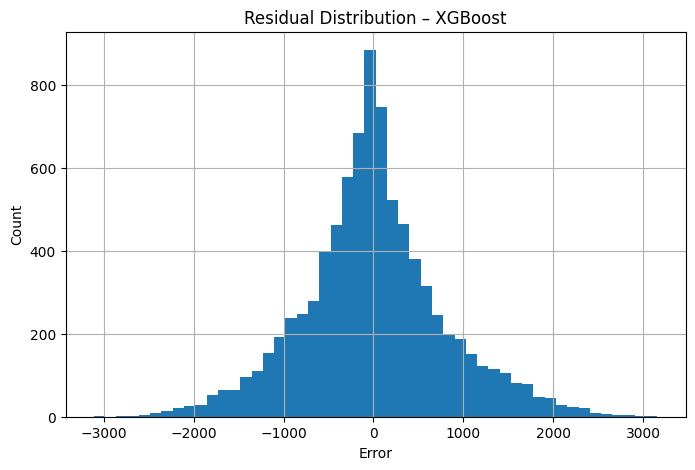

In [33]:
# Residual Analysis for XGBoost

import matplotlib.pyplot as plt
y_pred = pipeline_xgb.predict(X)
residuals = y - y_pred

plt.figure(figsize=(8,5))
plt.hist(residuals, bins=50)
plt.title('Residual Distribution – XGBoost')
plt.xlabel('Error')
plt.ylabel('Count')
plt.grid(True)
plt.show()

## 19. Final Submission with Stacked Model (Fallback if missing)

In [ ]:
# Merge tier predictions into sample
sample = sample.drop(columns=['Item_Outlet_Sales'], errors='ignore')  # clear any existing column

sample = sample.merge(
    tier_final,
    on=['Item_Identifier', 'Outlet_Identifier'],
    how='left'
)

# Rename merged column correctly if it's named with a suffix
if 'Item_Outlet_Sales_y' in sample.columns:
    sample['Item_Outlet_Sales'] = sample['Item_Outlet_Sales_y']
    sample.drop(columns=['Item_Outlet_Sales_x', 'Item_Outlet_Sales_y'], errors='ignore', inplace=True)

# Convert pred_stack (ndarray) to Series aligned to sample index
fallback_blend = pd.Series(pred_stack, index=sample.index)

# Use fallback for rows without tier prediction
sample['Item_Outlet_Sales'] = sample['Item_Outlet_Sales'].fillna(fallback_blend)

# Round predictions
sample['Item_Outlet_Sales'] = sample['Item_Outlet_Sales'].round(2)

# Save final stacked submission
sample[['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales']].to_csv('submission_final_stacked.csv', index=False)
print('Saved submission_final_stacked.csv')


✅ Saved submission_final_stacked.csv
